In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
project_name = 'Delft'
image_features_folder = r'Data\Delft\image_features'
network_data_path = r'C:\Users\lange\OneDrive\Documenten\Jaar_5-Msc_CE_TTE\DSAIE_STREETS\Data_old\Delft_NL'

name = 'edges_drive'
random_state = 22

variance = 0.8
number_of_components = 167
number_of_clusters = 7

In [3]:
with open(r'Data\Delft\edges_drive_vector_assignments.pkl', 'rb') as file:
    section_vectors = pickle.load(file)

network_ids = []
network_features = []
for id, features in section_vectors.items():
    network_ids.append(id)
    network_features.append(features)
network_features = np.array(network_features)

In [4]:
def scale_data(features):
    """Scale the data to 0-1 or normalize the data"""
    scaler = MinMaxScaler()
    
    return scaler.fit_transform(features)

# TODO: Rename variance to n_components and provide explanation
def dim_reduction(features, variance, random_state):
    """This function performs the dimensionality reduction"""
    pca = PCA(n_components=variance, svd_solver='full', random_state=random_state)
    pca = pca.fit(features)
    dim_reduced_features = pca.transform(features)

    return dim_reduced_features

def pca_kmeans(features, n_clusters, random_state):
    """Perform the Kmeans clustering for features after dimensionality reduction."""

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans = kmeans.fit(features)

    inertia = kmeans.inertia_
    return kmeans, inertia


def pca_hierarchical(features, n_clusters):
    """Perform the hierarchical clustering for features after dimensionality reduction."""
    # Using 'ward' linkage makes AgglomerativeClustering automatically use 'euclidean' as metric
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', compute_distances=True)
    hierarchical = hierarchical.fit(features)
    
    return hierarchical


def pca_gaussianmixture(features, n_clusters):
    """Perform the Gaussian Mixture clustering for features after dimensionality reduction."""
    # Covariance_type = 'full' ensure that each component has its own covariance matrix, which we want as the components are distinct from each other.
    gm = GaussianMixture(n_components = n_clusters, covariance_type="full").fit(features)
    gm_clusters = gm.predict(features)
    gm_prob = gm.predict_proba(features)
    
    return gm_clusters, gm_prob

Perform clustering:

In [5]:
features_scaled = scale_data(network_features)
features_dim_reduced = dim_reduction(features_scaled, variance=number_of_components, random_state=22)
clustering_km, _ = pca_kmeans(features_dim_reduced, number_of_clusters, random_state=22)
clustering_hr = pca_hierarchical(features_dim_reduced, number_of_clusters)
clustering_gm, probabilities_gm = pca_gaussianmixture(features_dim_reduced, number_of_clusters)

Visualize in various ways:

In [6]:
def visualize_tsne(features, km_labels, hr_labels, gm_labels, random_state: int=0):
    """Use TSNE to visualize the high dimension features with labeling to show their clusters""" 
    
    fig, axs = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(18)

    labels_list = [km_labels, hr_labels, gm_labels]
    titles = ['Kmeans', 'Hierarchical', 'Gaussian Mixture']

    for ax, labels, title in zip(axs, labels_list, titles):
        tsne = TSNE(n_components=2, random_state=random_state)
        feat_tsne = tsne.fit_transform(features)

        ax.scatter(feat_tsne[:,0], feat_tsne[:,1], c=labels, cmap='viridis', alpha=0.7)
        ax.set_title(title)

    plt.suptitle("Dimensionally Condensed Clustering Results")
    plt.show()

Below the graph is showing the results of using t-SNE to visualize the high-dimensional features. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. It can be seen that different colors are representing the clusters. This method provides a way to look into the data and compare different clustering methods. 

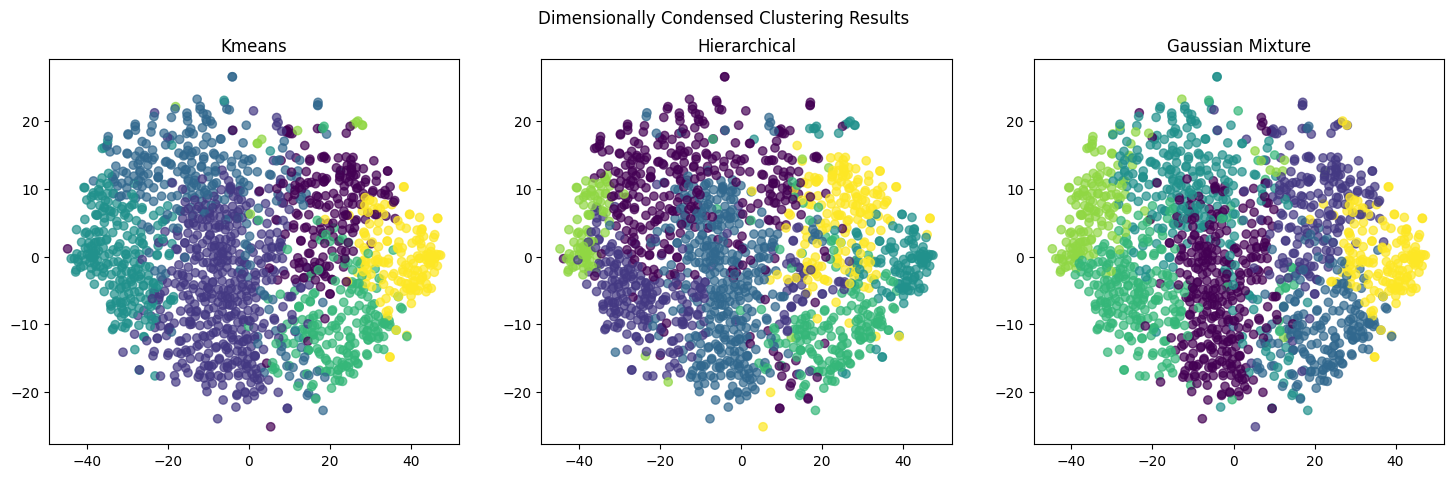

In [7]:
visualize_tsne(features_dim_reduced, clustering_km.labels_, clustering_hr.labels_, clustering_gm)

In [8]:
def plot_dendrogram_2(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.title('Hierarchical Clustering Results')
    plt.ylabel("Distance")
    plt.xlabel("Amount of Sections per cluster")

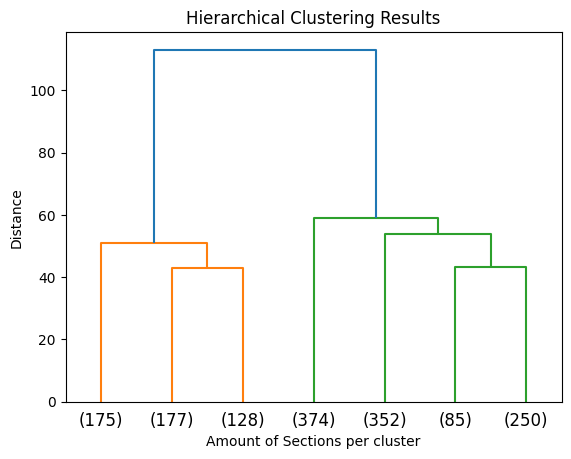

In [9]:
sampled_rows = np.random.choice(features_dim_reduced.shape[0], 200, replace=False)
plot_dendrogram_2(clustering_hr, truncate_mode="lastp", p=number_of_clusters)
# plot_dendrogram(clustering_hr) #should sample randomly 

Create a single dataframe of all the results

In [10]:
results_transposed = np.transpose([network_ids, clustering_km.labels_, clustering_hr.labels_, clustering_gm])
results_df = pd.DataFrame(results_transposed, columns=['section_id', 'cluster_km', 'cluster_hr', 'cluster_gm'])
results_df['cluster_km'] = results_df['cluster_km'].astype(int)
results_df['cluster_hr'] = results_df['cluster_hr'].astype(int)
results_df['cluster_gm'] = results_df['cluster_gm'].astype(int)
results_df

,section_id,cluster_km,cluster_hr,cluster_gm
0,48688450,4,1,4
1,7537370,1,1,4
2,144919697,2,2,3
3,7540079,1,2,0
4,760168344,2,0,3
...,...,...,...,...
1536,"[ 7468722, 7468718 ]",3,1,4
1537,4419934,2,0,2
1538,"[ 1091298518, 74976134 ]",6,3,6
1539,1021751269,4,4,2


In [11]:
def plot_heatmaps(clustering_results: pd.DataFrame, cmap_name: str='winter'):
    clustering_results = clustering_results.copy()

    km_vs_hr = clustering_results.drop(columns=['cluster_gm']).groupby(['cluster_km', 'cluster_hr'], group_keys=False).count()
    km_vs_hr = km_vs_hr.reset_index().pivot(columns='cluster_km',index='cluster_hr',values='section_id')
    km_vs_gm = clustering_results.drop(columns=['cluster_hr']).groupby(['cluster_km', 'cluster_gm'], group_keys=False).count()
    km_vs_gm = km_vs_gm.reset_index().pivot(columns='cluster_km',index='cluster_gm',values='section_id')
    hr_vs_gm = clustering_results.drop(columns=['cluster_km']).groupby(['cluster_hr', 'cluster_gm'], group_keys=False).count()
    hr_vs_gm = hr_vs_gm.reset_index().pivot(columns='cluster_hr',index='cluster_gm',values='section_id')

    fig, axs = plt.subplots(1, 3, figsize=(6,5))
    fig.set_figheight(5)
    fig.set_figwidth(18)

    base_color = plt.get_cmap(cmap_name)(0)

    # TODO: Set labels, titles, and suptitle
    for ax, df in zip(axs, [km_vs_hr, km_vs_gm, hr_vs_gm]):
        
        heatmap_i = sns.heatmap(df, cmap=cmap_name, ax=ax)
        heatmap_i.set_facecolor(base_color)
        # ax.set(xlabel=xlabel, ylabel=ylabel)
        ax.invert_yaxis()


List of heatmaps: https://matplotlib.org/stable/users/explain/colors/colormaps.html

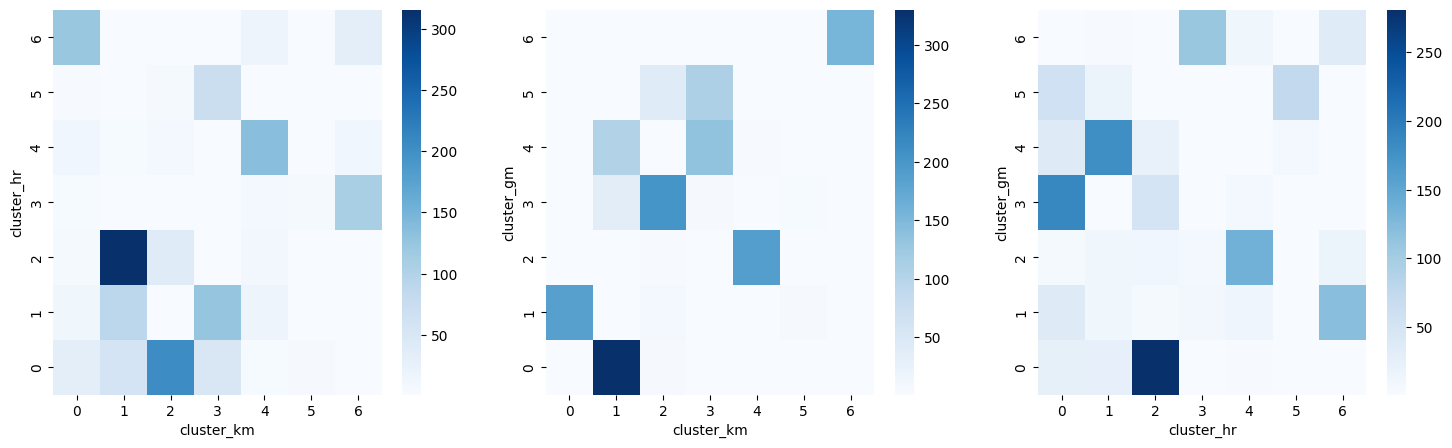

In [12]:
plot_heatmaps(results_df, cmap_name='Blues')

### Swapping cluster numbers

In [13]:
def renumber_clusters(clustering_results: pd.DataFrame, dominant: str, submissive: str, n_cluster: int) -> pd.DataFrame:

    sub_per_dom = clustering_results.drop(clustering_results.columns.difference([dominant, submissive, 'section_id']), axis=1).copy()
    sub_per_dom = sub_per_dom.groupby([dominant, submissive], group_keys=False).count()
    sub_per_dom = sub_per_dom.sort_values(by='section_id', ascending=False).reset_index()

    # Find best corresponding cluster numbers from dominant clustering type for submissive clustering type cluster numbers
    recluster = dict.fromkeys(range(n_cluster))
    taken = []
    for _, count in sub_per_dom.iterrows():
        if recluster[count[submissive]] is None and count[dominant] not in taken:
            recluster[count[submissive]] = count[dominant]
            taken.append(count[dominant])

    # Fill None clusters with random not taken clusters
    not_taken = [cluster for cluster in range(n_cluster) if cluster not in taken]
    for cluster_sub, cluster_dom in recluster.items():
        if cluster_dom is None:
            recluster[cluster_sub] = not_taken[0]
            not_taken.pop()

    # Change numbers to correct corresponding
    old_results = clustering_results.copy()
    new_results = clustering_results.copy()
    for cluster_sub, cluster_dom in recluster.items():
        new_results.loc[old_results[submissive] == cluster_sub, submissive] = cluster_dom

    # new_results[submissive] = new_results[submissive].astype('int')
    return new_results, recluster

In [14]:
new_results, recluster_hr = renumber_cluster(results_df, 'cluster_km', 'cluster_hr', number_of_clusters)
print(f"Result hr to km renumbering: {recluster_hr}")
new_results, recluster_gm = renumber_cluster(new_results, 'cluster_km', 'cluster_gm', number_of_clusters)
print(f"Result gm to km renumbering: {recluster_gm}")

Result hr to km renumbering: {0: 2, 1: 3, 2: 1, 3: 6, 4: 4, 5: 5, 6: 0}
Result gm to km renumbering: {0: 1, 1: 0, 2: 4, 3: 2, 4: 3, 5: 5, 6: 6}


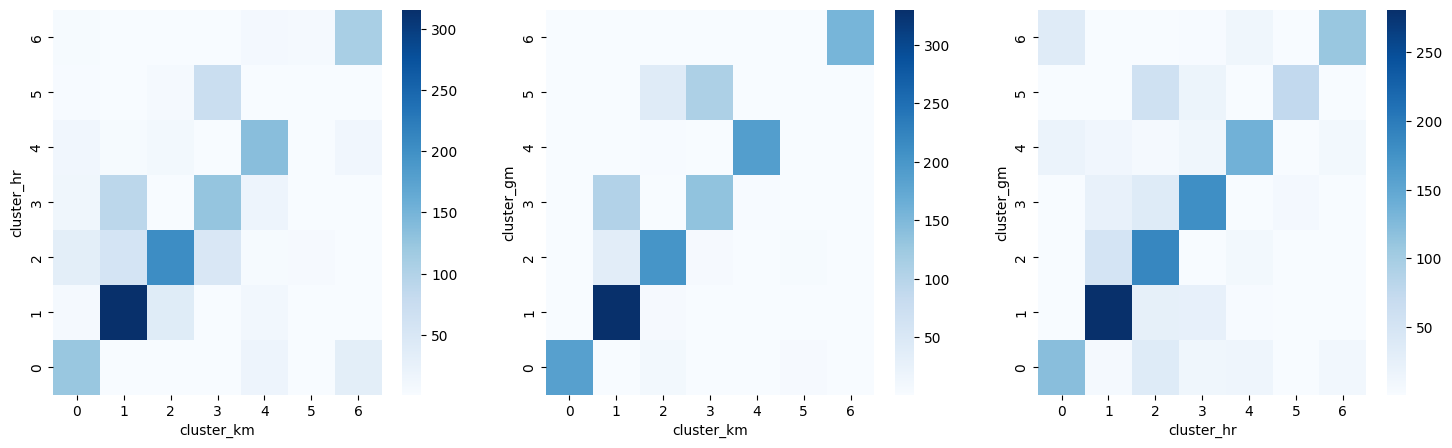

In [15]:
plot_heatmaps(new_results, cmap_name='Blues')

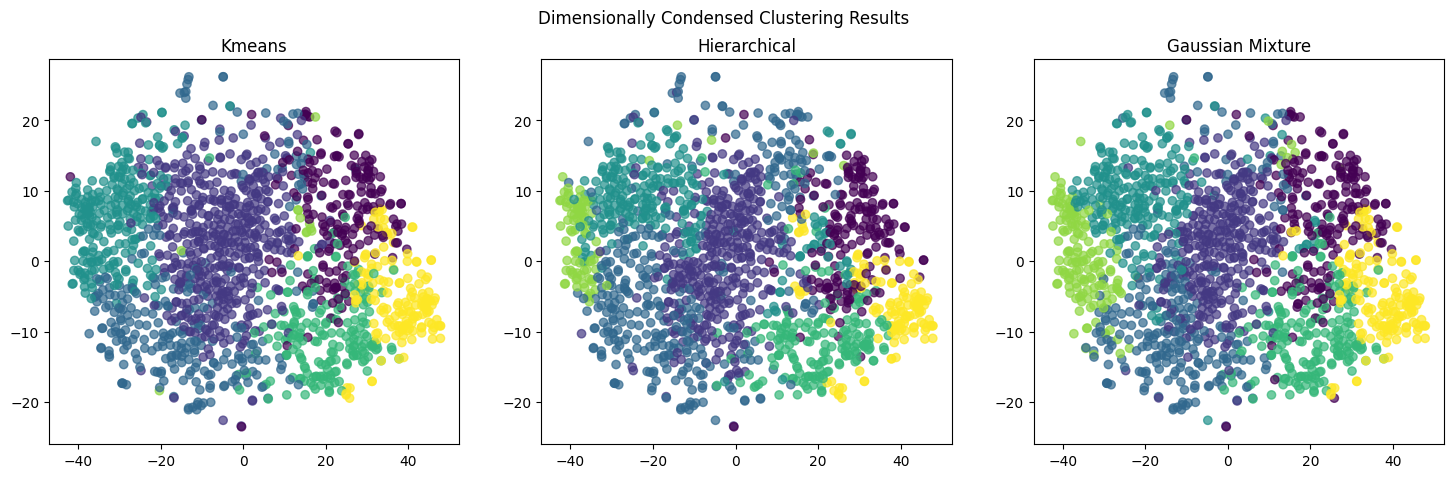

In [16]:
visualize_tsne(features_dim_reduced, new_results['cluster_km'], new_results['cluster_hr'], new_results['cluster_gm'], random_state=123)

In [19]:
new_results.to_csv(f"Data\\{project_name}\\{name}_clustering_results.csv", index=False)